In [1]:
import cv2
import os
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
np.random.seed(42)

import tensorflow as tf
tf.compat.v1.reset_default_graph()

In [2]:
import numpy as np
import keras
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
from keras.optimizers import SGD, Adam, RMSprop, Adagrad
from keras.preprocessing.image import ImageDataGenerator
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
!unzip  '/content/gdrive/My Drive/Colab_Dataset/Dataset3.zip'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
Archive:  /content/gdrive/My Drive/Colab_Dataset/Dataset3.zip
  inflating: New_Data_CoV2/Covid/Patient (10)/AnotaтАб╓╢o 2020-04-28 132320.png  
  inflating: New_Data_CoV2/Covid/Patient (10)/AnotaтАб╓╢o 2020-04-28 132449.png  
  inflating: New_Data_CoV2/Covid/Patient (10)/AnotaтАб╓╢o 2020-04-28 132516.png  
  inflating: New_Data_CoV2/Covid/Patient (10)/AnotaтАб╓╢o 2020-04-28 132540.png  
  inflating: New_Data_CoV2/Covid/Patient (10)/AnotaтАб╓╢o 2020-04-28 1326

In [4]:
IMG_CHANNELS = 1
IMG_ROWS = 32
IMG_COLS = 32

#CONSTANT
BATCH_SIZE = 32
NB_EPOCH = 1000
NB_CLASSES = 2
VERBOSE = 1
#VALIDATION_SPLIT = 0.15
#OPTIM = Adam(learning_rate=1)  # Other optimizers are SGD, Adam, RMSprop, Adagrad


In [7]:
image_location = []
image_label = []

dataset_path = 'New_Data_CoV2'
for folder in os.listdir(dataset_path):
    if(folder == 'Covid'):
        for subfolder in os.listdir(os.path.join(dataset_path, folder)):        
            for file in os.listdir(os.path.join(dataset_path, folder, subfolder)):
                filename, fileextension = os.path.splitext(file)     
                if(fileextension == '.png' or fileextension == '.jpg' or fileextension == '.jpeg'):     
                    file_path = os.path.join(dataset_path, folder,subfolder, file)
                    image_location.append(file_path)
                    image_label.append(1)
                
    else:
        for subfolder in os.listdir(os.path.join(dataset_path, folder)):   
            for file in os.listdir(os.path.join(dataset_path, folder, subfolder)):
                filename, fileextension = os.path.splitext(file)     
                if(fileextension == '.png' or fileextension == '.jpg' or fileextension == '.jpeg'):     
                    file_path = os.path.join(dataset_path, folder,subfolder, file)
                    image_location.append(file_path)
                    image_label.append(0)
        

In [8]:
def process_image():
    #Return two array. One of resize images and other of array of labels
    x = []  # array of images
    y = []  # array of labels
    WIDTH = 128
    HEIGHT = 128
    for img, label in zip(image_location, image_label):
        #Read and resize image
        full_size_image = cv2.imread(img)
        #full_size_gray_image = cv2.cvtColor(full_size_image, cv2.COLOR_BGR2GRAY)
        x.append(cv2.resize(full_size_image,(WIDTH, HEIGHT), interpolation=cv2.INTER_CUBIC))
        # Labels
        y.append(label)
              
    return x,y

x, y = process_image()

In [9]:
x = np.asarray(x)
y = np.asarray(y)
print('Shape of x: ',x.shape, '  Shape of y: ', y.shape)
print('Dimension of x: ', x.ndim, '  Dimension of y: ', y.ndim)
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 42)
print('Shape of X_train: ',X_train.shape, '  Shape of y_train: ', y_train.shape)
print('Shape of X_test: ',X_test.shape, '  Shape of y_test: ', y_test.shape)

Shape of x:  (4171, 128, 128, 3)   Shape of y:  (4171,)
Dimension of x:  4   Dimension of y:  1
Shape of X_train:  (3336, 128, 128, 3)   Shape of y_train:  (3336,)
Shape of X_test:  (835, 128, 128, 3)   Shape of y_test:  (835,)


In [21]:
def LetNet5():
    model = Sequential()
    model.add(Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=(X_train.shape[1:]), padding="same"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
    model.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
    model.add(Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='same'))
    model.add(Flatten())
    model.add(Dense(120,activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(84, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid',kernel_initializer='he_uniform'))
    model.compile(loss=keras.losses.binary_crossentropy, optimizer=RMSprop(1e-4), metrics=['accuracy'])
    model.summary()
    return model

In [22]:
from keras.models import Sequential, Model, Input
from keras.layers.core import Dense, Activation, Flatten, Dropout, Reshape
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
LetNet5 = LetNet5()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 128, 128, 6)       456       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 6)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 16)        2416      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 120)       48120     
_________________________________________________________________
flatten_2 (Flatten)          (None, 122880)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 120)              

In [23]:
train_datagen = ImageDataGenerator(
    rescale = 1.0/255.0,
    
    #zoom_range = 0.2,
    horizontal_flip = True
)


test_dataset = ImageDataGenerator(
    rescale = 1.0/255.0)


train_generator = train_datagen.flow(X_train,y_train, batch_size = BATCH_SIZE)



test_generator = test_dataset.flow(X_test,y_test, batch_size = BATCH_SIZE)


In [24]:
history_LetNet = LetNet5.fit_generator(train_generator,epochs=100,validation_data=test_generator)
                              

Epoch 1/100
105/105 [==============================] - 5s 47ms/step - loss: 0.5595 - accuracy: 0.6996 - val_loss: 0.7201 - val_accuracy: 0.4790
Epoch 2/100
105/105 [==============================] - 5s 45ms/step - loss: 0.4658 - accuracy: 0.7770 - val_loss: 0.6335 - val_accuracy: 0.5868
Epoch 3/100
105/105 [==============================] - 5s 44ms/step - loss: 0.4152 - accuracy: 0.8061 - val_loss: 0.7015 - val_accuracy: 0.5198
Epoch 4/100
105/105 [==============================] - 5s 44ms/step - loss: 0.3710 - accuracy: 0.8429 - val_loss: 0.5051 - val_accuracy: 0.7317
Epoch 5/100
105/105 [==============================] - 5s 45ms/step - loss: 0.3234 - accuracy: 0.8684 - val_loss: 0.4208 - val_accuracy: 0.8132
Epoch 6/100
105/105 [==============================] - 5s 45ms/step - loss: 0.2738 - accuracy: 0.8891 - val_loss: 0.3893 - val_accuracy: 0.8036
Epoch 7/100
105/105 [==============================] - 5s 45ms/step - loss: 0.2219 - accuracy: 0.9197 - val_loss: 0.5459 - val_accuracy:

Train Score:  0.0007206997834146023
Train Accuracy:  0.9997002482414246
Test Score:  0.7678998112678528
Test Accuracy:  0.8467065691947937


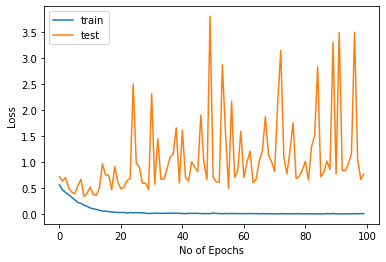

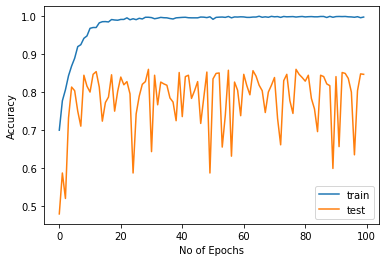

In [25]:
print('Train Score: ',LetNet5.evaluate_generator(train_generator)[0])
print('Train Accuracy: ',LetNet5.evaluate_generator(train_generator)[1])
print('Test Score: ',LetNet5.evaluate_generator(test_generator)[0])
print('Test Accuracy: ',LetNet5.evaluate_generator(test_generator)[1])

plt.plot(history_LetNet.history['loss'], label='train')
plt.plot(history_LetNet.history['val_loss'], label='test')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# learning curves of model accuracy
plt.plot(history_LetNet.history['accuracy'], label='train')
plt.plot(history_LetNet.history['val_accuracy'], label='test')
plt.xlabel('No of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [26]:
LetNet5.save('Saved Models/CNN3.h5')